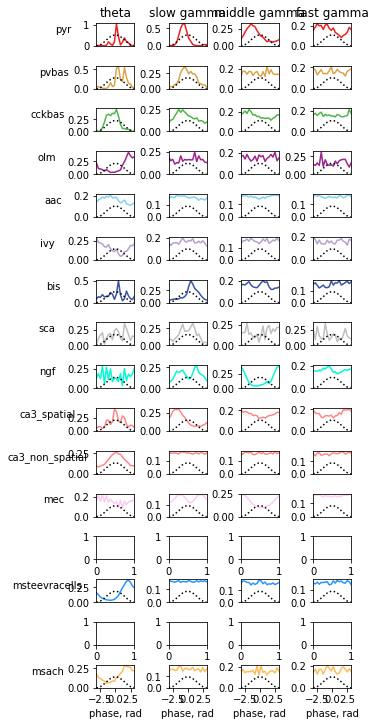

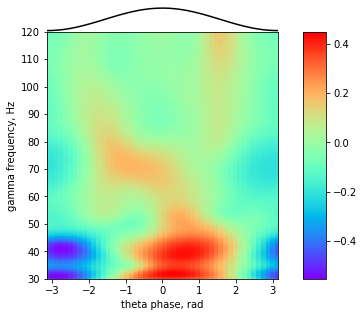

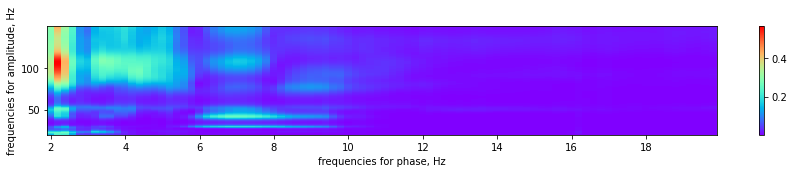

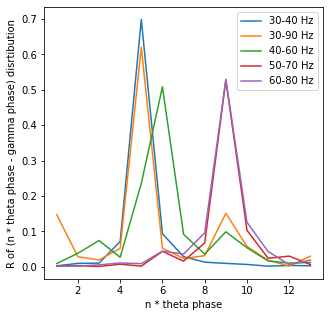

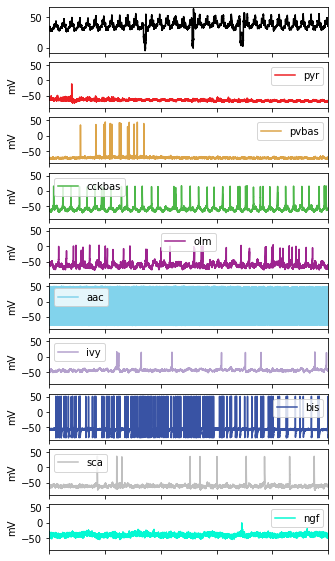

In [49]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 2)
# from basic_parameters import basic_params
import plot_result as my_plot

filepath = "../../Data/CA1_simulation/test.hdf5" #  basic_params["file_results"]
# my_plot.plot_v(filepath)

#my_plot.plot_spike_raster(filepath)
# my_plot.plot_lfp(filepath)
my_plot.plot_phase_disrtibution(filepath)
my_plot.plot_phase_by_amplitude_coupling(filepath)
# my_plot.plot_current_source_density(filepath, "theta")
my_plot.plot_modulation_index(filepath)
my_plot.plot_nm_phase_phase_coupling(filepath)
my_plot.plot_v_vs_pyr_lfp(filepath)
# my_plot.plot_phase_precession(filepath)

In [54]:
from process import processing_and_save

file = "../../Data/CA1_simulation/test_ripples.hdf5" # 
processing_and_save(file)



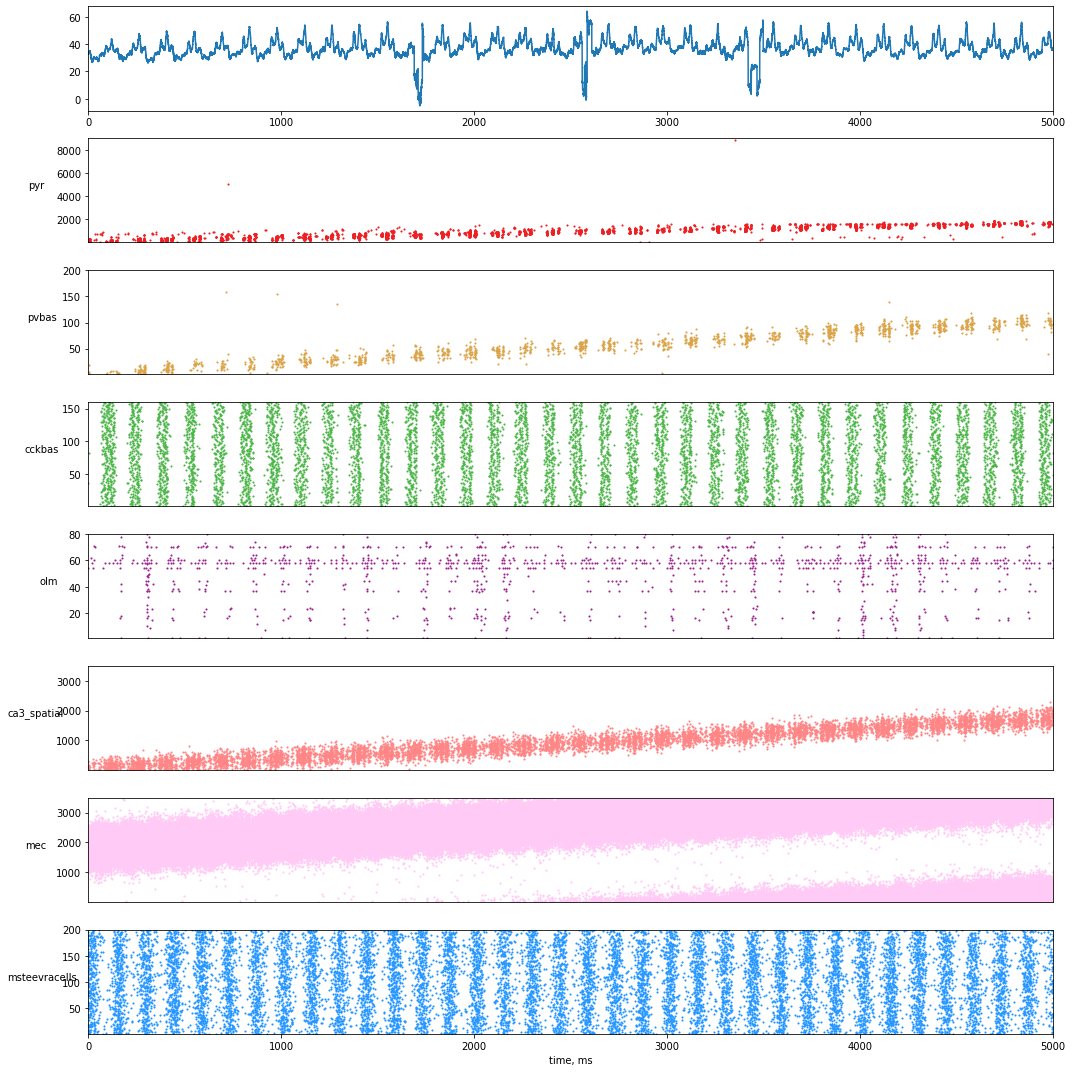

In [47]:
import numpy as np
# from scipy.signal import hilbert
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py
from plot_result import plotting_param
# from basic_parameters import basic_params
# import processingLib as proclib
plt.rcParams["figure.figsize"] = (15, 5)

# import plot_result as my_plot
# neuron_order = ["pyr", "pvbas"] # "pvbas", "cckbas", "olm", "bis", "aac", "ivy", "ngf", "sca", "mec", "ca3_spatial", "ca3_non_spatial", "msteevracells", "msach"]

neuron_order = ["pyr", "pvbas",  "cckbas", "olm", "ca3_spatial", "mec", "msteevracells"]

filepath = "../../Data/CA1_simulation/test_ripples.hdf5"  # test.hdf5" # # basic_params["file_results"]
# my_plot.plot_spike_raster(file)

with h5py.File(filepath, 'r') as h5file:
    t0 = h5file["time"][0]
    t1 = h5file["time"][-1]
    
    lfp = h5file["extracellular/electrode_1/lfp/origin_data/channel_1"][:] # np.ones(1000) #s
    t = np.linspace(t0, t1, lfp.size)
   
    raster_group = h5file["extracellular/electrode_1/firing/origin_data"]
                
    fig = plt.figure(figsize=(15, 15))
        
    neurons_num = len(neuron_order)
    gs = gridspec.GridSpec(neurons_num+1, 1)
    
    axes = plt.subplot(gs[0])
    axes.plot(t, lfp)
    axes.set_xlim(t0, t1)
    # axes.set_xlim(4000, 6000)

    for celltype_idx, celltype in enumerate(neuron_order):
        

        try:
            celltype_group = raster_group[celltype]
            axes = plt.subplot(gs[celltype_idx+1])
           
            # print("#########################")
            for sp_idx, (cell_key, firing) in enumerate(sorted(celltype_group.items(), key=lambda x: int(x[0].split("_")[-1]),)):
                # print(cell_key)
                sp_idx += 1
                color = plotting_param["neuron_colors"][celltype]
                axes.scatter(firing,  np.zeros(firing.size) + sp_idx, s=1.2, color=color )
                
                # if sp_idx > 3500 and celltype=="pyr": break

            axes.set_ylim(1, sp_idx)
            axes.set_xlim(t0, t1)
            # axes.set_xlim(4000, 6000)
            axes.set_ylabel(celltype, rotation='horizontal', labelpad=20)

            if celltype_idx == len(neuron_order) - 1:
                axes.set_xlabel("time, ms")
            else:
                axes.tick_params(labelbottom=False, bottom=False)
        except KeyError:
            continue
            
            
fig.tight_layout()
plt.show()

In [ ]:
print("hello")

9000
4
-0.1494149514951495 0.3105776131820719


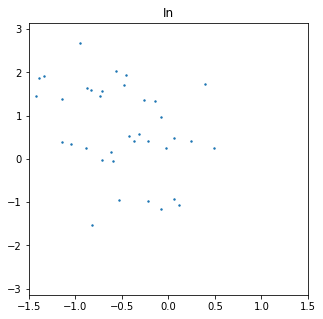

In [53]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import h5py
from scipy.stats import linregress
from scipy.optimize import minimize

class CircularLinearRegession:
    def __init__(self, phis, x):
        self.phis = phis
        self.x = x
        
    def angle_shift_from_slope(self, slope):
        
        phi_0 = np.angle( np.sum(np.exp(1j*(self.phis - 2*np.pi*slope*self.x))) )
        return phi_0

    def get_circ_linear_distance(self, slope):
        
        phi_0 = self.angle_shift_from_slope(slope)
        
        D = 2 * (1 - np.mean( np.cos(self.phis - 2*np.pi*slope*self.x - phi_0)  )  )
        
        return D
    
    def fit(self):
        slopes = np.linspace(-1, 1, 10000)
        D = []

        for slope in slopes:
            d = self.get_circ_linear_distance(slope)
            D.append(d)

        slope0 = slopes[ np.argmin(np.asarray(D)) ]
        
        optim_results = minimize(self.get_circ_linear_distance, slope0, method="COBYLA")
        
        self.slope = optim_results.x
        self.phi_0 = self.angle_shift_from_slope(self.slope)
        
        return self.slope, self.phi_0
    
    def transpose(self, x):
        phi_target = 2*np.pi*self.slope*x + self.phi_0
        return phi_target

def angles2range(phis):
    phis = phis % (2 * np.pi)
    phis[phis > np.pi] = phis[phis > np.pi] - 2*np.pi
    phis[phis < -np.pi] = phis[phis < -np.pi] + 2*np.pi
    return phis





def get_place_phase(filepath):

    x_4_preccs = np.empty(0, dtype=np.float)
    y_4_preccs = np.empty(0, dtype=np.float)

    with h5py.File(filepath, 'r') as h5file:
        sampling_rate = 0.1*h5file["extracellular/electrode_1/lfp/origin_data"].attrs["SamplingRate"]
        theta_signal = h5file["extracellular/electrode_1/lfp/processing/bands/channel_1/theta"][:]
        t = h5file["time"][:]
        # sampling_rate = 1000 / (t[1] - t[0])

        theta_phases = np.angle( hilbert(theta_signal) ) # + np.random.rand() * 2 * np.pi - np.pi # 2*np.pi*0.007*t+ np.random.rand() * 2 * np.pi - np.pi    # 
        # theta_phases = 2*np.pi*0.007*t #+ np.random.rand() * 2 * np.pi - np.pi    # 
        # theta_phases = theta_phases%(2*np.pi)
        # theta_phases[theta_phases>np.pi] -= 2*np.pi
        # theta_signal = np.cos(theta_phases)
        
        
        # theta_phases[theta_phases < 0] += 2*np.pi

        #plt.plot(t, theta_phases)

        Npyr = 9000 # 2000 # 
        pyr_coord_x = np.cumsum( np.zeros(Npyr) + 3 ) # np.zeros(Npyr) + 1400 # 
        pyr_coord_x[pyr_coord_x.size//2:] = np.nan 



        firing_group = h5file["extracellular/electrode_1/firing/origin_data/pyr"] # pyr !!!!
        #sampling_rate *= 0.001

        print( len(firing_group.keys() ) )
        #ax_out.set_title("Out")

        # for neuron_idx, firing in enumerate(firing_group.values()):
        counter = 0
        for neuron_idx, (cell_key, firing) in enumerate(sorted(firing_group.items(), key=lambda x: int(x[0].split("_")[-1]),)):
        #for neuron_idx, cell_key in enumerate(firing_group.keys() ):
            
            
            # print(cell_key)
           
            if firing.size < 10: continue
            
            
            counter += 1
            
           
            firing = firing[:] * 0.001
            
            indexes = (np.floor(firing * sampling_rate) - 1).astype(np.int)
            
            # firing = np.linspace(0, 2, 2000)
            

            place_center = pyr_coord_x[neuron_idx] * 0.001 # np.median(firing) # 
            if np.isnan(place_center) or place_center < 0.3 or place_center > 9.8:
                continue

            # print(place_center)

            place_center = place_center + 0.2 # np.median(firing) #

            firing_during_place = firing - place_center

            #if np.std(firing_during_place) > 5000: continue

            is_inside = np.abs(firing_during_place) < 2.0
            
            
            phases_during_place = theta_phases[indexes]

            firing_inside = firing_during_place[is_inside]
            phases_inside = phases_during_place[is_inside] 

            #ax_in.scatter(firing_inside, phases_inside, s=2)
            #ax_in.scatter(firing_inside, phases_inside+2*np.pi, s=2)

            x_4_preccs = np.append(x_4_preccs, firing_inside)
            y_4_preccs = np.append(y_4_preccs, phases_inside)
            #is_outside = np.logical_not(is_inside)
            #firing_outside = firing_during_place[is_outside]
            #phases_outside = phases_during_place[is_outside]

            # ax_out.scatter(firing_outside, phases_outside, s=2)
            # print(neuron_idx)
            # break
    
    print(counter)
    return x_4_preccs, y_4_preccs

path = "../../Data/CA1_simulation/"
#files = ["chan_1", "chan_2","chan_3","chan_4","chan_5","chan_6","chan_7","chan_8"]#  ["test", "test2", "test3"]
files =  ["test", ] # ["theta_state_very_nice!!!", ]# 
x_4_preccs = np.empty(0, dtype=np.float)
y_4_preccs = np.empty(0, dtype=np.float)
            

for file in files:
    filepath = path + file + ".hdf5"  # "../../Data/CA1_simulation/test3.hdf5" 
    #print(filepath)

    x_4_preccs_tmp, y_4_preccs_tmp = get_place_phase(filepath)

    x_4_preccs = np.append(x_4_preccs, x_4_preccs_tmp)
    y_4_preccs = np.append(y_4_preccs, y_4_preccs_tmp)

    
#y_4_preccs[y_4_preccs < 0] = y_4_preccs[y_4_preccs < 0] + 2*np.pi  
#phases = np.linspace(0, 2*np.pi, 50)
#cos_line = 200*np.cos(phases) + 800
fig_in, ax_in = plt.subplots(figsize=(5, 5))
#fig_out, ax_out = plt.subplots()


ax_in.set_title("In")
ax_in.scatter(x_4_preccs, y_4_preccs, s=2)


# line_x = np.array([-1.0, 1.0])
# line_y = line_x * res.slope + res.intercept
regressor = CircularLinearRegession(y_4_preccs, x_4_preccs)
slope, phi_0 = regressor.fit()

print(slope, phi_0)
# res = linregress(x_4_preccs, y=y_4_preccs)        
line_y = regressor.transpose(x_4_preccs)

line_y = angles2range(line_y)
line_y[line_y < 0] += 2*np.pi

#ax_in.scatter(x_4_preccs, line_y, color="red") #, linewidth=3)
#ax_in.plot(cos_line, phases, color="black", linewidth=1)

# print(res.rvalue**2, res.pvalue)
ax_in.set_xlim(-1.5, 1.5)
ax_in.set_ylim(-np.pi, np.pi)
plt.show()

In [ ]:
import numpy as np

dist = 0
var_conns_on_pyr = 100.0
var_conns_on_pvbas =  var_conns_on_pyr * 3
var_conns_pvbas2pvbas = var_conns_on_pyr * 50
dist_normalizer = np.exp(-0.5 * dist**2 / var_conns_on_pvbas ) / (np.sqrt(var_conns_on_pvbas * 2 * np.pi ))


Nca3 = 2000
ca3_coord_x =  np.cumsum( np.zeros(Nca3) + 3 )
print(ca3_coord_x[:10], ca3_coord_x.max())

(50.0, 300.0)

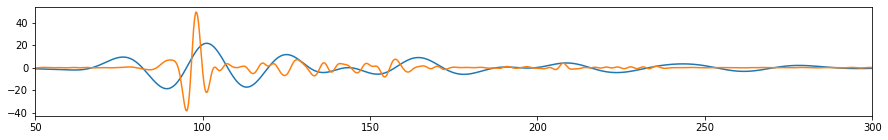

In [55]:
import numpy as np
# from scipy.signal import hilbert
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py
# from basic_parameters import basic_params
# import processingLib as proclib
plt.rcParams["figure.figsize"] = (15, 2)

filepath = "../../Data/CA1_simulation/test_ripples.hdf5"   # basic_params["file_results"]


with h5py.File(filepath, 'r') as h5file:
    t0 = h5file["time"][0]
    t1 = h5file["time"][-1]
    
    slow_gamma = h5file["extracellular/electrode_1/lfp/processing/bands/channel_3/slow gamma"][:]
    # middle_gamma = h5file["extracellular/electrode_1/lfp/processing/bands/channel_1/middle gamma"][:]
    # fast_gamma = h5file["extracellular/electrode_1/lfp/processing/bands/channel_1/fast gamma"][:]
    slow_ripples = h5file["extracellular/electrode_1/lfp/processing/bands/channel_3/slow ripples"][:]

t = np.linspace(t0, t1, slow_gamma.size)

fig, axes = plt.subplots(sharex=True)
axes.plot(t, slow_gamma)   
# axes.plot(t, middle_gamma)   
axes.plot(t, slow_ripples) 
axes.set_xlim(50, 300)
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nontheta_state_params import theta_state2non_theta_state_params
from basic_parameters_nice import get_object_params, get_basic_params

basic_params = get_basic_params()

basic_params = theta_state2non_theta_state_params(basic_params)

pyr_idx = 2000

objects = get_object_params(Nthreads=1)

neurons = objects[0]["neurons"]
synapses = objects[0]["synapses_params"]

pyr_coords = basic_params["pyr_coodinates"]
ca3_coords = basic_params["ca3_coodinates"]


print(pyr_coords[pyr_idx])

zero_pyr_idx = next(x for x, val in enumerate(objects[0]["cell_types_in_model"]) if val == "pyr")
zero_ca3_idx = next(x for x, val in enumerate(objects[0]["cell_types_in_model"]) if val == "ca3_spatial")

post_gid = pyr_idx + zero_pyr_idx

print(post_gid)
gmax_ca32pyr = []
gmax_coordca3 = []

#print(objects[0]["cell_types_in_model"])

for syn in synapses:
    #print(syn)
    if syn["post_gid"] != post_gid:
        continue

    if objects[0]["cell_types_in_model"][syn["pre_gid"]] != "ca3_spatial":
        continue
    
    pre_idx = syn["pre_gid"] - zero_ca3_idx
    # print(pre_idx)
    
    if pre_idx < 0:
        print("Below zero!!!!")
    
    gmax = syn["gmax"]
    
    gmax_ca32pyr.append(gmax)
    gmax_coordca3.append(pre_idx)

print(sum(gmax_ca32pyr))
plt.plot(gmax_coordca3, gmax_ca32pyr)
plt.show()




In [24]:
import h5py
filepath = "../../Data/CA1_simulation/test.hdf5"
    
with h5py.File(filepath, 'a') as h5file:
    p = h5file["extracellular/electrode_1/lfp"]
    print( p.keys() )
    
    try:
        del h5file["extracellular/electrode_1/lfp/processing"]
    except KeyError:
        print("Not del lfp processing")

    try:
        del h5file["extracellular/electrode_1/firing/processing"]
    except KeyError:
        print("Not del firing processing")

        

<KeysViewHDF5 ['origin_data']>
Not del lfp processing
Not del firing processing
